In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.datasets import CIFAR10
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.optim as optim

# Pre-processing

In [ ]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# define transforms for images
transform = transforms.Compose(
              [transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29645166.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Build model

The CNN model used here

In [ ]:
# Load the EfficientNetB0 model
effnet = models.efficientnet_b0(pretrained=True)


# Remove the last layer (classifier)
effnet.classifier = torch.nn.Identity()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:15<00:00, 1.41MB/s]


In [ ]:
# Add global average pooling, dropout, and dense layers
class Cifar10ClassfierModel(nn.Module):
    def __init__(self, effnet, num_classes):
        super(Cifar10ClassfierModel, self).__init__()
        self.effnet = effnet
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(1280)
        self.dropout = nn.Dropout(p=0.5)
        self.dense1 = nn.Linear(1280, 640)
        self.dense2 = nn.Linear(640, 320)
        self.dense3 = nn.Linear(320, 160)
        self.dense4 = nn.Linear(160, 10)
        self.dense = nn.Linear(1280, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.effnet(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense4(x)
        # x = self.sigmoid(x)
        return x

In [ ]:
# Create an instance of the classifier model

num_classes = 10  # Replace with the desired number of output classes
model = Cifar10ClassfierModel(effnet, num_classes)


In [ ]:
# Set the model to evaluation mode
model.train()

# Print the modified model architecture
print(model)

model.to(device)

Cifar10ClassfierModel(
  (effnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

Cifar10ClassfierModel(
  (effnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

In [ ]:
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              SiLU-6           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]             512
      BatchNorm2d-14           [-1, 16,

# train model

In [ ]:
# Define the optimizer and the initial learning rate
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Define the loss function
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/100], Loss: 1.2406978607177734,Accuracy:48.83%
Epoch [2/100], Loss: 1.3944034576416016,Accuracy:66.78%
Epoch [3/100], Loss: 0.7514228820800781,Accuracy:72.54%
Epoch [4/100], Loss: 1.2138570547103882,Accuracy:76.59%
Epoch [5/100], Loss: 1.009647011756897,Accuracy:79.24%
Epoch [6/100], Loss: 0.4465973973274231,Accuracy:81.43%
Epoch [7/100], Loss: 0.7933570742607117,Accuracy:83.25%
Epoch [8/100], Loss: 0.19280701875686646,Accuracy:84.88%
Epoch [9/100], Loss: 0.202923983335495,Accuracy:86.20%
Epoch [10/100], Loss: 0.4928300082683563,Accuracy:87.61%
Epoch [11/100], Loss: 0.4545426666736603,Accuracy:88.71%
Epoch [12/100], Loss: 0.9163568019866943,Accuracy:89.75%
Epoch [13/100], Loss: 0.6866024732589722,Accuracy:90.53%
Epoch [14/100], Loss: 0.5266370177268982,Accuracy:91.27%
Epoch [15/100], Loss: 0.15118764340877533,Accuracy:91.88%
Epoch [16/100], Loss: 0.1444709151983261,Accuracy:92.44%
Epoch [17/100], Loss: 0.6157842874526978,Accuracy:93.18%
Epoch [18/100], Loss: 0.5263715386390686

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

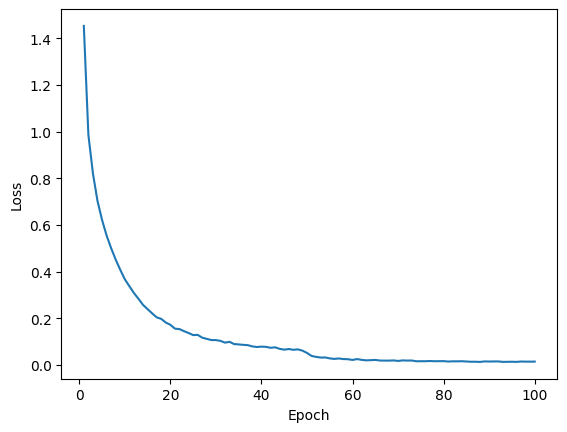

In [ ]:
# Train the model
num_epochs = 100
# Lists to store loss values for plotting
losses = []

for epoch in range(num_epochs):
    # Adjust the learning rate
    model.train()

    scheduler.step()
    total = 0
    correct = 0
    total_loss = 0.0
    # Train the model for one epoch
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    accuracy = correct / total
    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()},Accuracy:{100 * accuracy:.2f}%")

    # Change learning rate after 25 epochs
    if epoch == 50:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001

# Plot the loss diagram
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title

In [ ]:
model.eval()  # Set the model to evaluation mode

total = 0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = correct / total

# Print the accuracy on the test set
print(f"Accuracy on the test set: {100 * accuracy:.2f}%")


Accuracy on the test set: 84.94%


F1 Score: 0.8499865743646626
Confusion Matrix:
[[886  12  32  14  11   2   2   5  27   9]
 [ 14 930   2   1   2   1   3   1  11  35]
 [ 30   1 832  34  40  24  24  10   4   1]
 [ 18   6  40 739  35 110  30  16   4   2]
 [  8   2  53  38 837  17  19  22   3   1]
 [  7   2  25 166  25 733  10  27   4   1]
 [  6   1  31  41  20   6 893   0   2   0]
 [  8   1  19  30  40  37   4 858   0   3]
 [ 38  20   6   8   3   1   2   1 910  11]
 [ 22  51   4  14   3   1   4   9  16 876]]


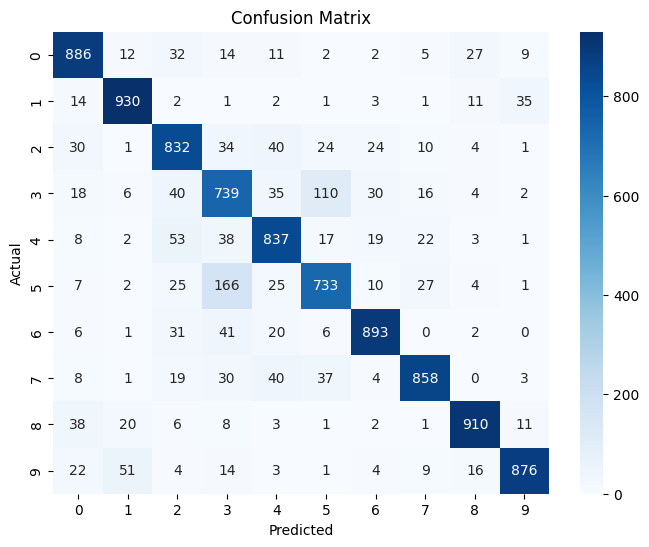

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import numpy as np

# Lists to store predicted labels and ground truth labels
pred_labels = []
true_labels = []

# Iterate over the test dataset and make predictions
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        pred_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Compute F1 score
f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(cm)


# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique([0,1,2,3,4,5,6,7,8,9]), yticklabels=np.unique([0,1,2,3,4,5,6,7,8,9]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from google.colab import files
torch.save(model, 'cifar10_classifier_model.pth')

# download checkpoint file
files.download('cifar10_classifier_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>